# Introduction

As the first part of this project to find the optimal location for a mexican restaurant in Madrid. It is first needed to analyze the city's most typical venues by neighborhood, so it is possible to have an idea of which are the actual leisure places where people go spend their time. To begin this analysis, neighborhood clusters will be created and their venues analysed in similarity terms.

Once the most frequent venues per neighborhood get extracted, for the second part of this project a segmentation by nationality of the people living in each neighborhood will be carried out, in order to determine in which neighborhood would be more advisable to open a mexican food restaurant based on the results of the previous segmentation and the analised venues.

For this project, the data that will be used to analyse the venues comes from the Foursquare API and the Madrid's City Hall. This project will be devoloped using the Python 3.6 programing language as the main working tool. To have access to the data used in this part, please refer to the first notebook: "Optimal location for a mexican restaurant". The data used in this motebook must be generated in the first notebook.

### Import necessary Libraries

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Read and explore the data

In [4]:
df = pd.read_csv('Madrid Neighborhoods.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
print(len(df))
df.head()

39


,Country of Procedence,Total Ciudad de Madrid,Centro,Arganzuela,Retiro,Salamanca,Chamartin,Tetuán,Chamberí,Fuencarral-El Pardo,Moncloa-Aravaca,Latina,Carabanchel,Usera,Puente de Vallecas,Moratalaz,Ciudad Lineal,Hortaleza,Villaverde,Villa de Vallecas,Vicálvaro,San Blas-Canillejas,Barajas
0,Rumanía,45036.0,815.0,754.0,480.0,753.0,680.0,1468.0,597.0,1830.0,991.0,4904.0,5873.0,2241.0,4784.0,1286.0,2888.0,1466.0,3646.0,3384.0,2606.0,2929.0,661.0
1,China,37276.0,1508.0,1356.0,564.0,755.0,652.0,1988.0,816.0,1733.0,960.0,2554.0,4398.0,9207.0,3602.0,564.0,1960.0,1104.0,1236.0,685.0,472.0,972.0,190.0
2,Ecuador,23953.0,647.0,741.0,265.0,619.0,380.0,1395.0,453.0,632.0,387.0,2194.0,3674.0,1806.0,3290.0,491.0,2471.0,401.0,2017.0,498.0,439.0,1015.0,138.0
3,Venezuela,23359.0,1563.0,913.0,638.0,1564.0,933.0,1310.0,794.0,1428.0,630.0,1448.0,1870.0,875.0,1829.0,480.0,1858.0,1434.0,909.0,762.0,321.0,1486.0,314.0
4,Colombia,22618.0,998.0,717.0,483.0,803.0,551.0,822.0,659.0,999.0,454.0,1786.0,3395.0,1752.0,1733.0,482.0,1792.0,910.0,1618.0,740.0,384.0,1282.0,258.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 23 columns):
Country of Procedence     37 non-null object
Total Ciudad de Madrid    34 non-null float64
Centro                    34 non-null float64
Arganzuela                34 non-null float64
Retiro                    34 non-null float64
Salamanca                 34 non-null float64
Chamartin                 34 non-null float64
Tetuán                    34 non-null float64
Chamberí                  34 non-null float64
Fuencarral-El Pardo       34 non-null float64
Moncloa-Aravaca           34 non-null float64
Latina                    34 non-null float64
Carabanchel               34 non-null float64
Usera                     34 non-null float64
Puente de Vallecas        34 non-null float64
Moratalaz                 34 non-null float64
Ciudad Lineal             34 non-null float64
Hortaleza                 34 non-null float64
Villaverde                34 non-null float64
Villa de Vallecas       

In [6]:
df.isnull().sum()

Country of Procedence     2
Total Ciudad de Madrid    5
Centro                    5
Arganzuela                5
Retiro                    5
Salamanca                 5
Chamartin                 5
Tetuán                    5
Chamberí                  5
Fuencarral-El Pardo       5
Moncloa-Aravaca           5
Latina                    5
Carabanchel               5
Usera                     5
Puente de Vallecas        5
Moratalaz                 5
Ciudad Lineal             5
Hortaleza                 5
Villaverde                5
Villa de Vallecas         5
Vicálvaro                 5
San Blas-Canillejas       5
Barajas                   5
dtype: int64

In [7]:
df.fillna(method = 'ffill', inplace = True)
df.fillna(method = 'bfill', inplace = True)

### Create a new dataframe with the coordinates of Madrid's neighborhoods

In [8]:
coordinates_df = pd.DataFrame( data = {

'Neighborhood' : ['Centro', 'Arganzuela', 'Retiro', 'Salamanca', 'Chamartin',
                'Tetuán', 'Chamberí', 'Fuencarral-El Pardo', 'Moncloa-Aravaca', 'Latina', 'Carabanchel',
                'Usera', 'Puente de Vallecas', 'Moratalaz', 'Ciudad Lineal', 'Hortaleza', 'Villaverde',
                'Villa de Vallecas', 'Vicálvaro', 'San Blas-Canillejas', 'Barajas'],
'Latitude' : ['40.415347', '40.402733', '40.408072', '40.43', '40.453333', '40.460556', '40.432792', '40.478611', '40.435151',
                 '40.402461', '40.383669', '40.381336', '40.398204', '40.409869', '40.45', '40.469457', '40.345925', '40.3796', 
                 '40.4042', '40.426001', '40.470196'],
'Longitude' : ['-3.707371', '-3.695403', '-3.676729', '-3.677778', '-3.6775', '-3.7', '-3.697186', '-3.709722', '-3.718765', 
                  '-3.741294', '-3.727989', '-3.706856', '-3.669059', '-3.644436', '-3.65', '-3.640482', '-3.709356', '-3.62135', 
                  '-3.60806', '-3.612764', '-3.58489']})

In [9]:
coordinates_df.head()

,Neighborhood,Latitude,Longitude
0,Centro,40.415347,-3.707371
1,Arganzuela,40.402733,-3.695403
2,Retiro,40.408072,-3.676729
3,Salamanca,40.43,-3.677778
4,Chamartin,40.453333,-3.6775


In [10]:
coordinates_df.info

<bound method DataFrame.info of            Neighborhood   Latitude  Longitude
0                Centro  40.415347  -3.707371
1            Arganzuela  40.402733  -3.695403
2                Retiro  40.408072  -3.676729
3             Salamanca      40.43  -3.677778
4             Chamartin  40.453333    -3.6775
5                Tetuán  40.460556       -3.7
6              Chamberí  40.432792  -3.697186
7   Fuencarral-El Pardo  40.478611  -3.709722
8       Moncloa-Aravaca  40.435151  -3.718765
9                Latina  40.402461  -3.741294
10          Carabanchel  40.383669  -3.727989
11                Usera  40.381336  -3.706856
12   Puente de Vallecas  40.398204  -3.669059
13            Moratalaz  40.409869  -3.644436
14        Ciudad Lineal      40.45      -3.65
15            Hortaleza  40.469457  -3.640482
16           Villaverde  40.345925  -3.709356
17    Villa de Vallecas    40.3796   -3.62135
18            Vicálvaro    40.4042   -3.60806
19  San Blas-Canillejas  40.426001  -3.612764
20

In [11]:
coordinates_df['Latitude'] = coordinates_df['Latitude'].astype('float', errors = 'ignore')
coordinates_df['Longitude'] = coordinates_df['Longitude'].astype('float', errors = 'ignore')
coordinates_df.dtypes

Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object

### Get latitudes and longitudes of Madrid

In [12]:
address = 'Madrid, Madrid'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Madrid are {}, {}.'.format(latitude, longitude))

C:\Users\bauer\Anaconda3\lib\site-packages\geopy\geocoders\osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinates of Madrid are 40.4167047, -3.7035825.


### Create a map of Madrid with its neighbourhoods

In [13]:
Madrid_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(coordinates_df['Latitude'], coordinates_df['Longitude'], coordinates_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(Madrid_map)  
    
Madrid_map

### Explore the Neighborhoods with Foursquare data

##### Define Foursquare credentials and version

In [14]:
CLIENT_ID = 'XNMD2E4XZXZ4BIHWUA24BQ2HMP1A25MFIAT5GXITZIWMA0T4' # Foursquare ID
CLIENT_SECRET = '25KDYDWFLH2WIC0CXUSOAGGGME5A1MKFVC21V0G2USNYUAKJ' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: XNMD2E4XZXZ4BIHWUA24BQ2HMP1A25MFIAT5GXITZIWMA0T4
CLIENT_SECRET:25KDYDWFLH2WIC0CXUSOAGGGME5A1MKFVC21V0G2USNYUAKJ


### Get the first Neighborhood's name

In [15]:
coordinates_df.loc[0, 'Neighborhood']

'Centro'

Now let's get the latitude and longitude of this neighborhood

In [16]:
neighborhood_latitude = coordinates_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = coordinates_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = coordinates_df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Centro are 40.415347, -3.707371.


### Get the top 100 venues in Rouge in a radius of 500 metters

In [17]:
LIMIT= 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

In [18]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5bcb2e42dd5797073fad9a73'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Plaza Mayor',
  'headerFullLocation': 'Plaza Mayor, Madrid',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 214,
  'suggestedBounds': {'ne': {'lat': 40.4198470045, 'lng': -3.701471589889844},
   'sw': {'lat': 40.410846995499995, 'lng': -3.7132704101101566}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4adcda37f964a520193c21e3',
       'name': 'Plaza Mayor',
       'location': {'address': 'Pl. Mayor',
        'lat': 40.415415259307935,
        'lng': -3.7076499019056968,
        'distance': 24,
        'postalCode': '28012',
        'cc': 'ES',
     

In [19]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [20]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Plaza Mayor,Plaza,40.415415,-3.707650
1,Mercado de San Miguel,Market,40.415363,-3.709042
2,La Taberna de Mister Pinkleton,Other Nightlife,40.414536,-3.708108
3,The Hat Madrid,Hotel,40.414343,-3.707120
4,Amorino,Ice Cream Shop,40.416065,-3.708383


In [21]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


### Now we are going to create a function that repeats all the above process for all the neighborhoods in Madrid, so we can explore these neighborhoods in more depth

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
Madrid_venues = getNearbyVenues(names= coordinates_df['Neighborhood'],
                                   latitudes= coordinates_df['Latitude'],
                                   longitudes= coordinates_df['Longitude']
                                  )


Centro
Arganzuela
Retiro
Salamanca
Chamartin
Tetuán
Chamberí
Fuencarral-El Pardo
Moncloa-Aravaca
Latina
Carabanchel
Usera
Puente de Vallecas
Moratalaz
Ciudad Lineal
Hortaleza
Villaverde
Villa de Vallecas
Vicálvaro
San Blas-Canillejas
Barajas


### Check the size of our new df

In [24]:
print(Madrid_venues.shape)
Madrid_venues.head()

(753, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Centro,40.415347,-3.707371,Plaza Mayor,40.415415,-3.707650,Plaza
1,Centro,40.415347,-3.707371,Mercado de San Miguel,40.415363,-3.709042,Market
2,Centro,40.415347,-3.707371,La Taberna de Mister Pinkleton,40.414536,-3.708108,Other Nightlife
3,Centro,40.415347,-3.707371,The Hat Madrid,40.414343,-3.707120,Hotel
4,Centro,40.415347,-3.707371,Amorino,40.416065,-3.708383,Ice Cream Shop


### How many venues are there by neighborhood?

In [25]:
Madrid_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arganzuela,80,80,80,80,80,80
Barajas,32,32,32,32,32,32
Carabanchel,7,7,7,7,7,7
Centro,100,100,100,100,100,100
Chamartin,53,53,53,53,53,53
Chamberí,100,100,100,100,100,100
Ciudad Lineal,28,28,28,28,28,28
Fuencarral-El Pardo,40,40,40,40,40,40
Hortaleza,21,21,21,21,21,21


### Let's now analyze our neighborhoods

In [26]:
# one hot encoding
madrid_onehot = pd.get_dummies(Madrid_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
madrid_onehot['Neighborhood'] = Madrid_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [madrid_onehot.columns[-1]] + list(madrid_onehot.columns[:-1])
madrid_onehot = madrid_onehot[fixed_columns]
#madrid_onehot = madrid_onehot[['Neighborhood',
madrid_onehot.head()

,Neighborhood,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Bookstore,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Camera Store,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Venue,Nightclub,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paella Restaurant,Park,Pastry Shop,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Polish Restaurant,Pub,Ramen Restaurant,Record Shop,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Trade School,Train Station,Vegetarian / Vegan Restaurant,Wine Bar,Yoga Studio
0,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
madrid_onehot.shape

(753, 155)

### Group by neighborhood and get the mean ocurrence of each venue category

In [28]:
madrid_grouped = madrid_onehot.groupby('Neighborhood').mean().reset_index()
madrid_grouped

,Neighborhood,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Bookstore,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Camera Store,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Venue,Nightclub,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paella Restaurant,Park,Pastry Shop,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Polish Restaurant,Pub,Ramen Restaurant,Record Shop,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Trade School,Train Station,Vegetarian / Vegan Restaurant,Wine Bar,Yoga Studio
0,Arganzuela,0.00,0.0125,0.000000,0.000000,0.00,0.012500,0.000000,0.000000,0.050000,0.012500,0.000000,0.037500,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.025000,0.025000,0.000,0.012500,0.000000,0.000000,0.000000,0.012500,0.00,0.000,0.0125,0.000000,0.00000,0.012500,0.000000,0.0125,0.000,0.00,0.0125,0.000000,0.000000,0.00,0.000,0.012500,0.000000,0.000000,0.000000,0.000000,0.000000,0.0125,0.000000,0.025000,0.012500,0.000000,0.000000,0.0125,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.012500,0.000,0.000000,0.00,0.000000,0.000000,0.050000,0.012500,0.037500,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.025000,0.000000,0.000000,0.00,0.0125,0.012500,0.012500,0.00,0.000000,0.000000,0.000000,0.0125,0.000000,0.000000,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012500,0.012500,0.012500,0.000000,0.0125,0.00,0.012500,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.025000,0.000000,0.012500,0.000000,0.000000,0.000000,0.00,0.100000,0.00,0.000000,0.000000,0.0125,0.025000,0.000000,0.0125,0.000000,0.00,0.000000,0.00,0.037500,0.000000,0.000000,0.00,0.087500,0.000000,0.000000,0.000000,0.000000,0.050000,0.00,0.0125,0.000,0.000,0.0125,0.012500,0.000000,0.00000,0.000000
1,Barajas,0.00,0.0000,0.031250,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,0.000000,0.00,0.000000,0.03125,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000,0.0000,0.000000,0.03125,0.062500,0.000000,0.0000,0.000,0.00,0.0000,0.000000,0.000000,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.062500,0.000000,0.0000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.031250,0.000,0.000000,

In [29]:
madrid_grouped.shape

(21, 155)

### 5 top venues by neighborhood

In [30]:
num_top_venues = 5

for hood in madrid_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = madrid_grouped[madrid_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arganzuela----
                venue  freq
0          Restaurant  0.10
1  Spanish Restaurant  0.09
2    Tapas Restaurant  0.05
3              Bakery  0.05
4       Grocery Store  0.05


----Barajas----
                  venue  freq
0                 Hotel  0.22
1            Restaurant  0.09
2    Spanish Restaurant  0.09
3           Coffee Shop  0.06
4  Fast Food Restaurant  0.06


----Carabanchel----
          venue  freq
0   Pizza Place  0.14
1     Nightclub  0.14
2  Soccer Field  0.14
3         Plaza  0.14
4        Bakery  0.14


----Centro----
                venue  freq
0  Spanish Restaurant  0.16
1    Tapas Restaurant  0.07
2               Plaza  0.05
3              Bistro  0.04
4               Hotel  0.04


----Chamartin----
                venue  freq
0  Spanish Restaurant  0.21
1          Restaurant  0.13
2              Bakery  0.06
3       Grocery Store  0.06
4         Pizza Place  0.06


----Chamberí----
                venue  freq
0  Spanish Restaurant  0.12
1            

### Function to sort the venues in descending order

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Now let's put this into a new pandas df and show the top ten venues per neighborhood

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = madrid_grouped['Neighborhood']

for ind in np.arange(madrid_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(madrid_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arganzuela,Restaurant,Spanish Restaurant,Bakery,Grocery Store,Tapas Restaurant,Beer Garden,Gym / Fitness Center,Snack Place,Brewery,Breakfast Spot
1,Barajas,Hotel,Spanish Restaurant,Restaurant,Tapas Restaurant,Coffee Shop,Fast Food Restaurant,Wine Bar,Argentinian Restaurant,Brewery,Japanese Restaurant
2,Carabanchel,Burger Joint,Fast Food Restaurant,Pizza Place,Soccer Field,Plaza,Nightclub,Bakery,Yoga Studio,Eastern European Restaurant,Farmers Market
3,Centro,Spanish Restaurant,Tapas Restaurant,Plaza,Restaurant,Hotel,Bistro,Wine Bar,Mexican Restaurant,Bar,Italian Restaurant
4,Chamartin,Spanish Restaurant,Restaurant,Pizza Place,Grocery Store,Gastropub,Bakery,Tapas Restaurant,Café,Park,Japanese Restaurant
5,Chamberí,Spanish Restaurant,Restaurant,Bar,Brewery,Hotel,Japanese Restaurant,Tapas Restaurant,Italian Restaurant,Plaza,Café
6,Ciudad Lineal,Spanish Restaurant,Burger Joint,Argentinian Restaurant,Restaurant,Gastropub,Supermarket,Gym / Fitness Center,Bakery,Pizza Place,Shopping Mall
7,Fuencarral-El Pardo,Clothing Store,Italian Restaurant,Fast Food Restaurant,Burger Joint,Bar,Tapas Restaurant,American Restaurant,Pizza Place,Snack Place,Coffee Shop
8,Hortaleza,Pizza Place,Breakfast Spot,Spanish Restaurant,Park,Clothing Store,Donut Shop,Plaza,Chinese Restaurant,Pub,Restaurant
9,Latina,Metro Station,Pizza Place,Park,Bakery,Food & Drink Shop,Fast Food Restaurant,Falafel Restaurant,Bar,Beer Bar,Grocery Store


# Get neighborhoods's clusters

### First, let's determine the optimal value of K for our dataset using the Elbow method

In [33]:
madrid_grouped_clustering = madrid_grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1, 22)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(madrid_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

### Plot and visualize optimal K

In [34]:
optimal_k= pd.DataFrame(data= Sum_of_squared_distances, columns = ['Sum_of_squared_distances'], index = K)
optimal_k.rename_axis('K', axis = 'columns', inplace = True)
#optimal_k

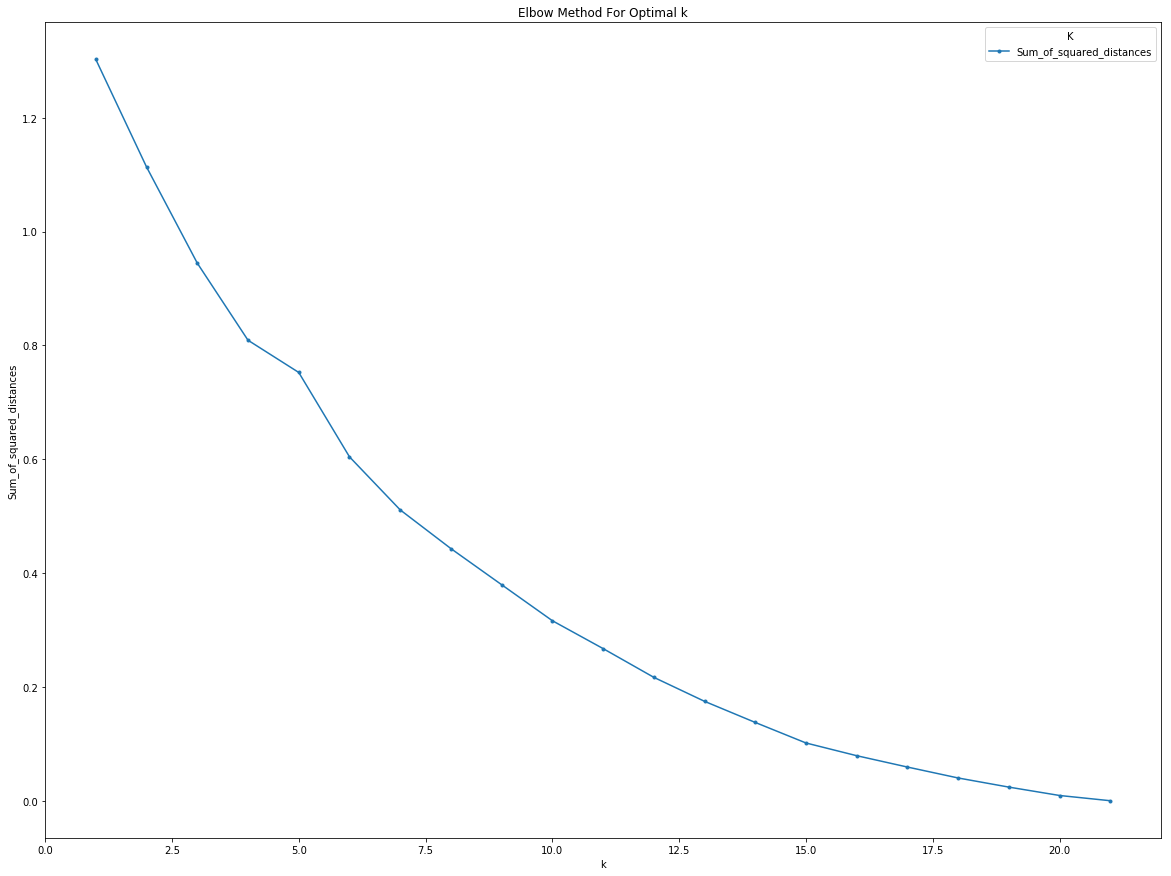

In [35]:
optimal_k.plot(kind = 'line', figsize = (20, 15), marker = '.')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

It seems that our best suitable K value is 5.

In [61]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(madrid_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 3, 0, 0, 4, 0, 4, 4, 1])

### Now let's put our cluster labels in our neighborhoods_venues_sorted df

First, we need to remove the rows in our original df for which the Foursquare call didn't return any venues

In [62]:
df['Neighborhood'] = neighborhoods_venues_sorted['Neighborhood']
print(df.shape)
df.isnull().sum()
df.dropna(how = 'any', axis = 0, inplace = True)
print(df.shape)
print(neighborhoods_venues_sorted.shape)

(21, 25)
(21, 25)
(21, 11)


# Segment the neighborhoods by population's nationalities and most common venues

### Now we are going to create a new df that contains the cluster labels as well as the top 10 venues per neighborhood

In [63]:
madrid_merged = df

# add clustering labels
madrid_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
madrid_merged = madrid_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
madrid_merged[['Latitude', 'Longitude']] = coordinates_df[['Latitude', 'Longitude']]
madrid_merged['Latitude'] = madrid_merged['Latitude'].astype(float)
madrid_merged['Longitude'] = madrid_merged['Longitude'].astype(float)
print(madrid_merged.shape)
madrid_merged.head() # check the last columns!

(21, 37)


,Country of Procedence,Total Ciudad de Madrid,Centro,Arganzuela,Retiro,Salamanca,Chamartin,Tetuán,Chamberí,Fuencarral-El Pardo,Moncloa-Aravaca,Latina,Carabanchel,Usera,Puente de Vallecas,Moratalaz,Ciudad Lineal,Hortaleza,Villaverde,Villa de Vallecas,Vicálvaro,San Blas-Canillejas,Barajas,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
0,Rumanía,45036.0,815.0,754.0,480.0,753.0,680.0,1468.0,597.0,1830.0,991.0,4904.0,5873.0,2241.0,4784.0,1286.0,2888.0,1466.0,3646.0,3384.0,2606.0,2929.0,661.0,Arganzuela,4,Restaurant,Spanish Restaurant,Bakery,Grocery Store,Tapas Restaurant,Beer Garden,Gym / Fitness Center,Snack Place,Brewery,Breakfast Spot,40.415347,-3.707371
1,China,37276.0,1508.0,1356.0,564.0,755.0,652.0,1988.0,816.0,1733.0,960.0,2554.0,4398.0,9207.0,3602.0,564.0,1960.0,1104.0,1236.0,685.0,472.0,972.0,190.0,Barajas,4,Hotel,Spanish Restaurant,Restaurant,Tapas Restaurant,Coffee Shop,Fast Food Restaurant,Wine Bar,Argentinian Restaurant,Brewery,Japanese Restaurant,40.402733,-3.695403
2,Ecuador,23953.0,647.0,741.0,265.0,619.0,380.0,1395.0,453.0,632.0,387.0,2194.0,3674.0,1806.0,3290.0,491.0,2471.0,401.0,2017.0,498.0,439.0,1015.0,138.0,Carabanchel,3,Burger Joint,Fast Food Restaurant,Pizza Place,Soccer Field,Plaza,Nightclub,Bakery,Yoga Studio,Eastern European Restaurant,Farmers Market,40.408072,-3.676729
3,Venezuela,23359.0,1563.0,913.0,638.0,1564.0,933.0,1310.0,794.0,1428.0,630.0,1448.0,1870.0,875.0,1829.0,480.0,1858.0,1434.0,909.0,762.0,321.0,1486.0,314.0,Centro,0,Spanish Restaurant,Tapas Restaurant,Plaza,Restaurant,Hotel,Bistro,Wine Bar,Mexican Restaurant,Bar,Italian Restaurant,40.430000,-3.677778
4,Colombia,22618.0,998.0,717.0,483.0,803.0,551.0,822.0,659.0,999.0,454.0,1786.0,3395.0,1752.0,1733.0,482.0,1792.0,910.0,1618.0,740.0,384.0,1282.0,258.0,Chamartin,0,Spanish Restaurant,Restaurant,Pizza Place,Grocery Store,Gastropub,Bakery,Tapas Restaurant,Café,Park,Japanese Restaurant,40.453333,-3.677500


### Now, let's visualize our clusters

In [64]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(madrid_merged['Latitude'], madrid_merged['Longitude'], madrid_merged['Neighborhood'], madrid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Now we can examine our clusters

#### Cluster One:

In [65]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 0, madrid_merged.columns[[0] + list(range(5, madrid_merged.shape[1]))]].sort_values(by = ['Country of Procedence'], ascending = False)

,Country of Procedence,Salamanca,Chamartin,Tetuán,Chamberí,Fuencarral-El Pardo,Moncloa-Aravaca,Latina,Carabanchel,Usera,Puente de Vallecas,Moratalaz,Ciudad Lineal,Hortaleza,Villaverde,Villa de Vallecas,Vicálvaro,San Blas-Canillejas,Barajas,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
3,Venezuela,1564.0,933.0,1310.0,794.0,1428.0,630.0,1448.0,1870.0,875.0,1829.0,480.0,1858.0,1434.0,909.0,762.0,321.0,1486.0,314.0,Centro,0,Spanish Restaurant,Tapas Restaurant,Plaza,Restaurant,Hotel,Bistro,Wine Bar,Mexican Restaurant,Bar,Italian Restaurant,40.430000,-3.677778
19,Reino Unido,550.0,466.0,329.0,501.0,313.0,304.0,211.0,170.0,81.0,142.0,59.0,285.0,319.0,61.0,49.0,27.0,120.0,74.0,Villa de Vallecas,0,Food,Spanish Restaurant,Train Station,Grocery Store,Soccer Field,Plaza,Motorcycle Shop,Church,Farmers Market,Falafel Restaurant,40.426001,-3.612764
13,Portugal,695.0,534.0,590.0,509.0,693.0,365.0,533.0,658.0,283.0,597.0,173.0,612.0,727.0,302.0,262.0,168.0,565.0,191.0,Retiro,0,Spanish Restaurant,Supermarket,Museum,Grocery Store,Tapas Restaurant,Gourmet Shop,Brewery,Burger Joint,Restaurant,Italian Restaurant,40.409869,-3.644436
6,Italia,1817.0,1060.0,1194.0,1640.0,1195.0,710.0,826.0,915.0,412.0,704.0,310.0,1258.0,1109.0,330.0,427.0,189.0,786.0,337.0,Ciudad Lineal,0,Spanish Restaurant,Burger Joint,Argentinian Restaurant,Restaurant,Gastropub,Supermarket,Gym / Fitness Center,Bakery,Pizza Place,Shopping Mall,40.432792,-3.697186
18,Estados Unidos de América,749.0,389.0,300.0,657.0,297.0,428.0,207.0,125.0,86.0,139.0,232.0,252.0,206.0,54.0,51.0,33.0,101.0,57.0,Vicálvaro,0,Spanish Restaurant,Breakfast Spot,Pizza Place,Café,Fast Food Restaurant,Coffee Shop,Beer Bar,Asian Restaurant,Grocery Store,Sandwich Place,40.404200,-3.608060
4,Colombia,803.0,551.0,822.0,659.0,999.0,454.0,1786.0,3395.0,1752.0,1733.0,482.0,1792.0,910.0,1618.0,740.0,384.0,1282.0,258.0,Chamartin,0,Spanish Restaurant,Restaurant,Pizza Place,Grocery Store,Gastropub,Bakery,Tapas Restaurant,Café,Park,Japanese Restaurant,40.453333,-3.677500
17,Bulgaria,113.0,123.0,245.0,74.0,316.0,170.0,996.0,988.0,395.0,760.0,285.0,780.0,283.0,516.0,261.0,269.0,662.0,92.0,Usera,0,Seafood Restaurant,Bubble Tea Shop,Fast Food Restaurant,Theater,Asian Restaurant,Chinese Restaurant,Spanish Restaurant,Fabric Shop,Flea Market,Fish Market,40.379600,-3.621350
16,Brasil,431.0,280.0,567.0,322.0,361.0,234.0,1159.0,1596.0,410.0,604.0,201.0,421.0,388.0,417.0,223.0,81.0,308.0,91.0,Tetuán,0,Spanish Restaurant,Brazilian Restaurant,Grocery Store,Coffee Shop,Supermarket,Burger Joint,Brewery,Farmers Market,Clothing Store,Seafood Restaurant,40.345925,-3.709356


#### Cluster Two:

In [66]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 1, madrid_merged.columns[[0] + list(range(5, madrid_merged.shape[1]))]].sort_values(by = ['Country of Procedence'], ascending = False)

,Country of Procedence,Salamanca,Chamartin,Tetuán,Chamberí,Fuencarral-El Pardo,Moncloa-Aravaca,Latina,Carabanchel,Usera,Puente de Vallecas,Moratalaz,Ciudad Lineal,Hortaleza,Villaverde,Villa de Vallecas,Vicálvaro,San Blas-Canillejas,Barajas,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
15,Ucrania,220.0,176.0,221.0,149.0,312.0,168.0,1745.0,1251.0,428.0,912.0,239.0,348.0,282.0,1649.0,256.0,152.0,390.0,56.0,San Blas-Canillejas,1,Metro Station,Supermarket,Gym,Grocery Store,Asian Restaurant,Pizza Place,Snack Place,Eastern European Restaurant,Fast Food Restaurant,Farmers Market,40.469457,-3.640482
9,República Dominicana,344.0,322.0,2272.0,443.0,589.0,536.0,1501.0,1607.0,1202.0,1989.0,223.0,1581.0,359.0,1881.0,296.0,151.0,889.0,103.0,Latina,1,Metro Station,Pizza Place,Park,Bakery,Food & Drink Shop,Fast Food Restaurant,Falafel Restaurant,Bar,Beer Bar,Grocery Store,40.402461,-3.741294


#### Cluster Three:

In [67]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 2, madrid_merged.columns[[0] + list(range(5, madrid_merged.shape[1]))]].sort_values(by = ['Country of Procedence'], ascending = False)

,Country of Procedence,Salamanca,Chamartin,Tetuán,Chamberí,Fuencarral-El Pardo,Moncloa-Aravaca,Latina,Carabanchel,Usera,Puente de Vallecas,Moratalaz,Ciudad Lineal,Hortaleza,Villaverde,Villa de Vallecas,Vicálvaro,San Blas-Canillejas,Barajas,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
20,Bangladesh,32.0,21.0,210.0,48.0,27.0,14.0,257.0,410.0,175.0,649.0,23.0,179.0,27.0,489.0,57.0,32.0,78.0,2.0,Villaverde,2,Brewery,Pizza Place,Diner,Spanish Restaurant,Electronics Store,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market,Falafel Restaurant,40.470196,-3.58489


#### Cluster Four:

In [68]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 3, madrid_merged.columns[[0] + list(range(5, madrid_merged.shape[1]))]].sort_values(by = ['Country of Procedence'], ascending = False)

,Country of Procedence,Salamanca,Chamartin,Tetuán,Chamberí,Fuencarral-El Pardo,Moncloa-Aravaca,Latina,Carabanchel,Usera,Puente de Vallecas,Moratalaz,Ciudad Lineal,Hortaleza,Villaverde,Villa de Vallecas,Vicálvaro,San Blas-Canillejas,Barajas,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
2,Ecuador,619.0,380.0,1395.0,453.0,632.0,387.0,2194.0,3674.0,1806.0,3290.0,491.0,2471.0,401.0,2017.0,498.0,439.0,1015.0,138.0,Carabanchel,3,Burger Joint,Fast Food Restaurant,Pizza Place,Soccer Field,Plaza,Nightclub,Bakery,Yoga Studio,Eastern European Restaurant,Farmers Market,40.408072,-3.676729
11,Bolivia,342.0,315.0,576.0,280.0,401.0,225.0,1458.0,2625.0,2827.0,1573.0,227.0,1086.0,479.0,737.0,222.0,159.0,454.0,71.0,Moratalaz,3,Brewery,Ice Cream Shop,Nightclub,Plaza,Restaurant,Falafel Restaurant,Fast Food Restaurant,Café,Food Truck,Soccer Field,40.381336,-3.706856


#### Cluster Five

In [69]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 4, madrid_merged.columns[[0] + list(range(5, madrid_merged.shape[1]))]].sort_values(by = ['Country of Procedence'], ascending = False)

,Country of Procedence,Salamanca,Chamartin,Tetuán,Chamberí,Fuencarral-El Pardo,Moncloa-Aravaca,Latina,Carabanchel,Usera,Puente de Vallecas,Moratalaz,Ciudad Lineal,Hortaleza,Villaverde,Villa de Vallecas,Vicálvaro,San Blas-Canillejas,Barajas,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
0,Rumanía,753.0,680.0,1468.0,597.0,1830.0,991.0,4904.0,5873.0,2241.0,4784.0,1286.0,2888.0,1466.0,3646.0,3384.0,2606.0,2929.0,661.0,Arganzuela,4,Restaurant,Spanish Restaurant,Bakery,Grocery Store,Tapas Restaurant,Beer Garden,Gym / Fitness Center,Snack Place,Brewery,Breakfast Spot,40.415347,-3.707371
7,Perú,612.0,419.0,965.0,567.0,805.0,368.0,2026.0,2425.0,1131.0,2079.0,668.0,1726.0,603.0,1280.0,564.0,338.0,810.0,106.0,Fuencarral-El Pardo,4,Clothing Store,Italian Restaurant,Fast Food Restaurant,Burger Joint,Bar,Tapas Restaurant,American Restaurant,Pizza Place,Snack Place,Coffee Shop,40.478611,-3.709722
8,Paraguay,521.0,657.0,3311.0,584.0,1024.0,636.0,2061.0,2152.0,727.0,1354.0,360.0,1619.0,583.0,870.0,217.0,199.0,581.0,151.0,Hortaleza,4,Pizza Place,Breakfast Spot,Spanish Restaurant,Park,Clothing Store,Donut Shop,Plaza,Chinese Restaurant,Pub,Restaurant,40.435151,-3.718765
5,Marruecos,322.0,280.0,1393.0,320.0,930.0,342.0,1539.0,2223.0,942.0,3437.0,258.0,1011.0,426.0,3372.0,1655.0,802.0,649.0,333.0,Chamberí,4,Spanish Restaurant,Restaurant,Bar,Brewery,Hotel,Japanese Restaurant,Tapas Restaurant,Italian Restaurant,Plaza,Café,40.460556,-3.700000
10,Honduras,332.0,337.0,755.0,317.0,863.0,335.0,2021.0,2870.0,1115.0,2483.0,281.0,1062.0,349.0,1040.0,387.0,165.0,598.0,62.0,Moncloa-Aravaca,4,Bar,Spanish Restaurant,Tapas Restaurant,Sandwich Place,Japanese Restaurant,Mediterranean Restaurant,Beer Garden,Bakery,Pizza Place,Ice Cream Shop,40.383669,-3.727989
14,Francia,968.0,554.0,387.0,699.0,366.0,347.0,196.0,188.0,66.0,138.0,85.0,599.0,1802.0,68.0,59.0,52.0,357.0,197.0,Salamanca,4,Spanish Restaurant,Seafood Restaurant,Restaurant,Coffee Shop,Tapas Restaurant,Clothing Store,Japanese Restaurant,Café,Mexican Restaurant,Mediterranean Restaurant,40.450000,-3.650000
12,Filipinas,578.0,661.0,4473.0,771.0,442.0,568.0,629.0,400.0,225.0,418.0,76.0,590.0,300.0,140.0,25.0,24.0,152.0,30.0,Puente de Vallecas,4,Fast Food Restaurant,Grocery Store,Hotel,Gym,Tapas Restaurant,Bakery,Bar,Café,South American Restaurant,Ice Cream Shop,40.398204,-3.669059
1,China,755.0,652.0,1988.0,816.0,1733.0,960.0,2554.0,4398.0,9207.0,3602.0,564.0,1960.0,1104.0,1236.0,685.0,472.0,972.0,190.0,Barajas,4,Hotel,Spanish Restaurant,Restaurant,Tapas Restaurant,Coffee Shop,Fast Food Restaurant,Wine Bar,Argentinian Restaurant,Brewery,Japanese Restaurant,40.402733,-3.695403


# Conclusions:

As far as we are able to see with this data, there are no mexican populations registered in Madrid. However, in Cluster 1, it is possible to notice that there's a mexican restaurant located in the "Centro" neighborhood, which is the town center. 

If a deeper exam is performed into this cluster, it is noticeable that its the living population are mostly latinos, mixed with some other europeans, but mainly, the people living in this cluster come from south american countries. Apart of this fact, other kinds of latin restaurants can be found, like argetinian restaurants, tapas restaurants, and italian restaurants. So it is possible to tell that the inhabitants of this area likes these kinds of food.

By following this logic, if we would like to open a new mexican restaurant in the city or any kind of restaurant in fact, it would only be necessary to find a where are the restaurants similar the the one we want to open, study the population in that area, and find similar clusters of population in the city that don't have yet or have very few resturants like the one we would like to open.

In this example, clusters 4 and 5 could make a good match for our target population. Looking at the venues in these clusters, it is possible to find one mexican restaurant, and a good bunch of fast food, argentinian, and south american restaurants. So, in these clusters, it is possible to state that the existing restaurants matches the population's nationalities and tastes.

In conlussion, and taking into consideration the explanations given above as well as the data, it is highly possible that clusters 4 and five could be a good place to open our mexican restaurants. As explained above, the same logic could apply to oopen other kind of restaurant or business in any other area of the city. It is only necessary to to examine the the existing businesses in our target area, and study the population, then compare these 2 factors with the same ones in areas where there are existing business like the one we want to open, and then verify if the matching is correct.